In [21]:
# Notebook to test completed ML model v3
# Uses all negatiove links
# Test model link prediction and community detection features
# Test triangles and clustering

In [22]:
from py2neo import Graph
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import pandas as pd
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
graph = Graph("bolt://localhost", auth=("neo4j", "123"))
import pickle

In [23]:
filename = 'd:\projectdata\Models\CDMLWU_V860.sav'
lrclassifier = pickle.load(open(filename,'rb'))
# Feature column names
columns = [
    "cn","aa", "pa", "tn","ra", # graph features
    "lp", "lv",
    "minT", "maxT", "minC", "maxC", # triangle features     
    "sn"                            # same name feature
]

In [24]:
#Function to down sample negative examples
def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0]
    un = Counter(copy.label.values)[1]
    n = zero - un
    copy = copy.drop(copy[copy.label == 0].sample(n=n, random_state=1).index)
    return copy.sample(frac=1)

def evaluate_model(predictions, actual):
    return pd.DataFrame({
        "Measure": ["Accuracy", "Precision", "Recall"],
        "Score": [accuracy_score(actual, predictions), 
                  precision_score(actual, predictions), 
                  recall_score(actual, predictions)]
    })

def feature_importance(columns, classifier):        
    display("Feature Importance")
    df = pd.DataFrame({
        "Feature": columns,
        "Importance": classifier.feature_importances_
    })
    df = df.sort_values("Importance", ascending=False)    
    ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
    ax.xaxis.set_label_text("")
    plt.tight_layout()
    plt.show()

In [25]:
def create_LP_features(data, rel_type):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1:Person) 
    USING INDEX p1:Person(connectionid) 
    WHERE p1.connectionid = pair.node1
    MATCH (p2:Person) 
    USING INDEX p2:Person(connectionid) 
    WHERE p2.connectionid = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           algo.linkprediction.commonNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS cn,
           algo.linkprediction.adamicAdar(
               p1, p2, {relationshipQuery: $relType}) AS aa,
           algo.linkprediction.preferentialAttachment(
               p1, p2, {relationshipQuery: $relType}) AS pa,
           algo.linkprediction.totalNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS tn,
           algo.linkprediction.resourceAllocation(
               p1, p2, {relationshipQuery: $relType}) AS ra
               
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    features = graph.run(query, {"pairs": pairs, "relType": rel_type}).to_data_frame()
    features = features.drop_duplicates()
    return pd.merge(data, features, on = ["node1", "node2"])

def create_community_features(data, triangles_prop, coefficient_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1:Person) 
    USING INDEX p1:Person(connectionid) 
    WHERE p1.connectionid = pair.node1
    MATCH (p2:Person) 
    USING INDEX p2:Person(connectionid) 
    WHERE p2.connectionid = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    apoc.coll.min([p1[$trianglesProp], p2[$trianglesProp]]) AS minT,
    apoc.coll.max([p1[$trianglesProp], p2[$trianglesProp]]) AS maxT,
    apoc.coll.min([p1[$coefficientProp], p2[$coefficientProp]]) AS minC,
    apoc.coll.max([p1[$coefficientProp], p2[$coefficientProp]]) AS maxC
    """    
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]    
    params = {
    "pairs": pairs,
    "trianglesProp": triangles_prop,
    "coefficientProp": coefficient_prop
    }
    features = graph.run(query, params).to_data_frame()
    features = features.drop_duplicates()
    return pd.merge(data, features, on = ["node1", "node2"])

def communitydetection_features(data, partition_prop, louvain_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1:Person) 
    USING INDEX p1:Person(connectionid) 
    WHERE p1.connectionid = pair.node1
    MATCH (p2:Person) 
    USING INDEX p2:Person(connectionid) 
    WHERE p2.connectionid = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    algo.linkprediction.sameCommunity(p1, p2, $partitionProp) AS lp,    
    algo.linkprediction.sameCommunity(p1, p2, $louvainProp) AS lv
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    params = {
    "pairs": pairs,
    "partitionProp": partition_prop,
    "louvainProp": louvain_prop
    }
    features = graph.run(query, params).to_data_frame()
    features = features.drop_duplicates()
    return pd.merge(data, features, on = ["node1", "node2"])

def samename_features(data, samename_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1:Person) 
    USING INDEX p1:Person(connectionid) 
    WHERE p1.connectionid = pair.node1
    MATCH (p2:Person) 
    USING INDEX p2:Person(connectionid) 
    WHERE p2.connectionid = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    algo.linkprediction.sameCommunity(p1, p2, $samenameProp) AS sn
"""
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    params = {
    "pairs": pairs,
    "samenameProp": samename_prop
    }
    features = graph.run(query, params).to_data_frame()
    features = features.drop_duplicates()
    return pd.merge(data, features, on = ["node1", "node2"])

In [26]:
# Load candidate names for prediction
linknames = pd.read_csv('d:/projectdata/ModelInput/names.csv')

#Build the Cypher query
cytext1="""
MATCH (p1:Person {FullName: 
"""
cytext2="""
WHERE (p1)-[:Knows]-()
MATCH (p1)-[:Knows*1..2]-(p2:Person)
WHERE not((p1)-[:Knows]-(p2))
RETURN p1.connectionid AS node1, p2.connectionid AS node2, 0 AS label
"""
# Create a new datafram
all_links = pd.DataFrame()

In [27]:
# Loop through the list of names
for row in linknames.itertuples():
    # Create the Cypher query with the name inserted
    cytext3 = '"' + row.PersonLabel + '"})'
    cytext3 = cytext3.replace('\n', '').replace('\r', '')
    cytext1 = cytext1.replace('\n', '').replace('\r', '')
    cytext4 = cytext1 + cytext3 + cytext2
    
    #Run the query against Neo4J
    no_links = graph.run(cytext4).to_data_frame()
    #Append a list of negative links to the dataframe 
    all_links = all_links.append(no_links,ignore_index=True)

In [28]:
all_links= all_links.drop_duplicates()
all_links.count()

node1    14681
node2    14681
label    14681
dtype: int64

In [29]:
# Apply graphs algorithms to node pairs
# use the main graph not a sub-graph
all_links= create_LP_features(all_links,"Knows")

In [30]:
# Apply community features to data
# Setup label propagation

graph.run("""
CALL algo.labelPropagation("Person", "Knows", "BOTH",
{iterations:20, partitionProperty: "lpcommunity"});
""").to_data_frame()

,loadMillis,computeMillis,writeMillis,postProcessingMillis,nodes,communityCount,iterations,didConverge,p1,p5,...,p50,p75,p90,p95,p99,p100,weightProperty,write,partitionProperty,writeProperty
0,27,14,2,34,700,56,9,True,3,4,...,11,14,19,26,29,42,weight,True,lpcommunity,lpcommunity


In [31]:
graph.run("""
CALL algo.louvain.stream("Person", "Knows", {includeIntermediateCommunities:false})
YIELD nodeId, community, communities
WITH algo.getNodeById(nodeId) AS node, community AS smallestCommunity
SET node.klouvain = smallestCommunity;
""").stats()

constraints_added: 0
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 700
relationships_created: 0
relationships_deleted: 0

In [32]:
#graph.run("""
#CALL algo.louvain.stream("Person", "Knows", {includeIntermediateCommunities:true})
#YIELD nodeId, community, communities
#WITH algo.getNodeById(nodeId) AS node, communities[2] AS lcommunity
#SET node.klouvain = lcommunity;
#""").stats()

In [33]:
all_links = communitydetection_features(all_links, "lpcommunity", "klouvain")

In [34]:
# Apply Triangle features to node pairs
# Setup data in graphDB
graph.run("""
CALL algo.triangleCount('Person', 'Knows', { write:true,
writeProperty:'triangles', clusteringCoefficientProperty:'clustercoef'});
""").to_data_frame()

all_links = create_community_features(all_links,"triangles","clustercoef")

In [35]:
# Use the same surname feature extractor
all_links = samename_features(all_links, "surnameID")

In [36]:
all_links.to_csv('d:/projectdata/ModelOutput//ModelData/CDMLWU_V8Clay2.csv')

In [37]:
predictions=lrclassifier.predict(all_links[columns])
predictpct=lrclassifier.predict_proba(all_links[columns])

In [38]:
pd.DataFrame(predictions).to_csv('d:/projectdata/ModelOutput/ModelData/CDMLWU_V8Clay_P2.csv')

In [39]:
pd.DataFrame(predictpct).to_csv('d:/projectdata/ModelOutput/ModelData/CDMLWU_V8Clay_PCT2.csv')

C:\Users\mscal\Anaconda3\envs\GraphML2\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Measure,Score
0,Accuracy,0.961
1,Precision,0.000
2,Recall,0.000


'Feature Importance'

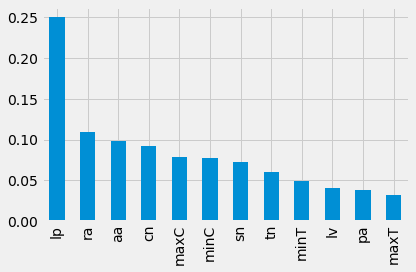

In [40]:
y_test = all_links["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, lrclassifier)